In [2]:
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set plot style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

# Data paths
DATA_DIR = Path('/shared/edo/Projects/Squidiff_data/')
RAW_COUNTS = DATA_DIR / 'raw_counts.csv.zip'
LOG_NORM_COUNTS = DATA_DIR / 'log_normalised_counts.csv.zip'
METADATA = DATA_DIR / 'cell_metadata_cols.tsv'

In [3]:
# Load metadata
print("Loading metadata...")
metadata = pd.read_csv(METADATA, sep='\t', index_col=0)
print(f"Metadata shape: {metadata.shape}")
print(f"\nColumns: {list(metadata.columns)}")
metadata.head()

Loading metadata...
Metadata shape: (36044, 93)

Columns: ['assigned', 'auxDir', 'cell_filter', 'cell_name', 'compatible_fragment_ratio', 'day', 'donor', 'expected_format', 'experiment', 'frag_dist_length', 'gc_bias_correct', 'is_cell_control', 'is_cell_control_bulk', 'is_cell_control_control', 'library_types', 'libType', 'log10_total_counts', 'log10_total_counts_endogenous', 'log10_total_counts_ERCC', 'log10_total_counts_feature_control', 'log10_total_counts_MT', 'log10_total_features', 'log10_total_features_endogenous', 'log10_total_features_ERCC', 'log10_total_features_feature_control', 'log10_total_features_MT', 'mapping_type', 'mates1', 'mates2', 'n_alt_reads', 'n_total_reads', 'num_assigned_fragments', 'num_bias_bins', 'num_bootstraps', 'num_compatible_fragments', 'num_consistent_mappings', 'num_inconsistent_mappings', 'num_libraries', 'num_mapped', 'num_processed', 'num_targets', 'nvars_used', 'pct_counts_endogenous', 'pct_counts_ERCC', 'pct_counts_feature_control', 'pct_counts_

,assigned,auxDir,cell_filter,cell_name,compatible_fragment_ratio,day,donor,expected_format,experiment,frag_dist_length,...,donor_short_id,donor_long_id,pseudo,PC1_top100hvgs,PC1_top200hvgs,PC1_top500hvgs,PC1_top1000hvgs,PC1_top2000hvgs,princ_curve,princ_curve_scaled01
21843_1#10,1,aux_info,True,21843_1#10,0.999497,day1,joxm,IU,expt_09,1001,...,joxm_1,HPSI0114i-joxm_1,0.292682,-13.353833,-12.969161,-11.769526,-12.153335,-12.871002,39.972588,0.352570
21843_1#100,1,aux_info,True,21843_1#100,0.999456,day1,fafq,IU,expt_09,1001,...,fafq_1,HPSI0314i-fafq_1,0.484716,2.399795,4.633188,5.131531,7.883242,9.916888,56.433387,0.497759
21843_1#101,1,aux_info,True,21843_1#101,0.999549,day1,fafq,IU,expt_09,1001,...,fafq_1,HPSI0314i-fafq_1,0.403809,-0.612621,0.006692,-0.643021,0.185298,-0.425978,52.966142,0.467177
21843_1#102,1,aux_info,True,21843_1#102,0.999422,day1,wuye,IU,expt_09,1001,...,wuye_2,HPSI1013i-wuye_2,0.260772,-11.946009,-12.691233,-14.508021,-15.328236,-18.071351,38.419984,0.338876
21843_1#103,1,aux_info,True,21843_1#103,0.999446,day1,joxm,IU,expt_09,1001,...,joxm_1,HPSI0114i-joxm_1,0.355366,-5.735735,-5.389405,-5.802985,-6.625860,-9.430127,48.488060,0.427679


In [4]:
# Determine which dataset to use for detailed QC
# We'll use raw counts for QC as it's the standard practice
print("Loading full raw counts dataset...")
print("This may take several minutes...")

raw_counts = pd.read_csv(RAW_COUNTS, index_col=0, low_memory=False)
print(f"Raw counts shape: {raw_counts.shape}")
print(f"Memory usage: {raw_counts.memory_usage(deep=True).sum() / 1e9:.2f} GB")

Loading full raw counts dataset...
This may take several minutes...
Raw counts shape: (11231, 36044)
Memory usage: 3.24 GB


In [5]:
# Check orientation (cells x genes or genes x cells)
print(f"Index (rows): {raw_counts.index[:5].tolist()}")
print(f"Columns: {raw_counts.columns[:5].tolist()}")

# Typically, if index contains '#' it's cell IDs
# If columns are gene names (e.g., start with letters), then it's cells x genes
is_cells_x_genes = any('#' in str(idx) for idx in raw_counts.index[:10])
print(f"\nOrientation appears to be: {'cells x genes' if is_cells_x_genes else 'genes x cells'}")

# Transpose if needed
if not is_cells_x_genes:
    print("Transposing to cells x genes...")
    raw_counts = raw_counts.T

Index (rows): ['ENSG00000000003_TSPAN6', 'ENSG00000000419_DPM1', 'ENSG00000000457_SCYL3', 'ENSG00000000460_C1orf112', 'ENSG00000001036_FUCA2']
Columns: ['21843_1#10', '21843_1#100', '21843_1#101', '21843_1#102', '21843_1#103']

Orientation appears to be: genes x cells
Transposing to cells x genes...


In [6]:
from anndata import AnnData

# Align counts and metadata
common_cells = raw_counts.index.intersection(metadata.index)
print(f"Common cells between counts and metadata: {len(common_cells)}")
print(f"Cells only in counts: {len(raw_counts.index) - len(common_cells)}")
print(f"Cells only in metadata: {len(metadata.index) - len(common_cells)}")

# Subset to common cells
raw_counts_aligned = raw_counts.loc[common_cells]
metadata_aligned = metadata.loc[common_cells]

# Create AnnData
adata = AnnData(
    X=raw_counts_aligned.values.astype(np.float32),
    obs=metadata_aligned,
    var=pd.DataFrame(index=raw_counts_aligned.columns.astype(str))
)

print(f"\nAnnData object created: {adata.n_obs} cells x {adata.n_vars} genes")

Common cells between counts and metadata: 36044
Cells only in counts: 0
Cells only in metadata: 0

AnnData object created: 36044 cells x 11231 genes


In [7]:
adata.obs["day"].unique()

array(['day1', 'day3', 'day0', 'day2'], dtype=object)

In [8]:
adata.var['gene_name'] = adata.var.index.map(lambda x: x.split('_', 1)[1] if '_' in x else x)
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var.gene_name.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var.gene_name.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata.var["hb"] = adata.var.gene_name.str.contains("^HB[^(P)]")

sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
)
     
# Define QC thresholds (adjust based on data)
min_genes = 1000
max_genes = 10000
max_mt_pct = 20

print(f"Before QC filtering: {adata.n_obs} cells")

# Filter cells
sc.pp.filter_cells(adata, min_genes=min_genes)
print(f"After min_genes filter: {adata.n_obs} cells")

adata = adata[adata.obs['n_genes_by_counts'] < max_genes, :]
print(f"After max_genes filter: {adata.n_obs} cells")

adata = adata[adata.obs['pct_counts_mt'] < max_mt_pct, :]
print(f"After MT% filter: {adata.n_obs} cells")

# Filter genes (remove genes expressed in very few cells)
min_cells = 10
print(f"\nBefore gene filtering: {adata.n_vars} genes")
sc.pp.filter_genes(adata, min_cells=min_cells)


# remove ribo and mito genes
adata = adata[:, ~adata.var["mt"]]
adata = adata[:, ~adata.var["ribo"]]
print(f"After gene filtering: {adata.n_vars} genes")

print(f"\nFinal QC-filtered dataset: {adata.n_obs} cells x {adata.n_vars} genes")

Before QC filtering: 36044 cells
After min_genes filter: 36044 cells
After max_genes filter: 35747 cells
After MT% filter: 35747 cells

Before gene filtering: 11231 genes
After gene filtering: 11089 genes

Final QC-filtered dataset: 35747 cells x 11089 genes


In [9]:
# normalize and log transform
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)

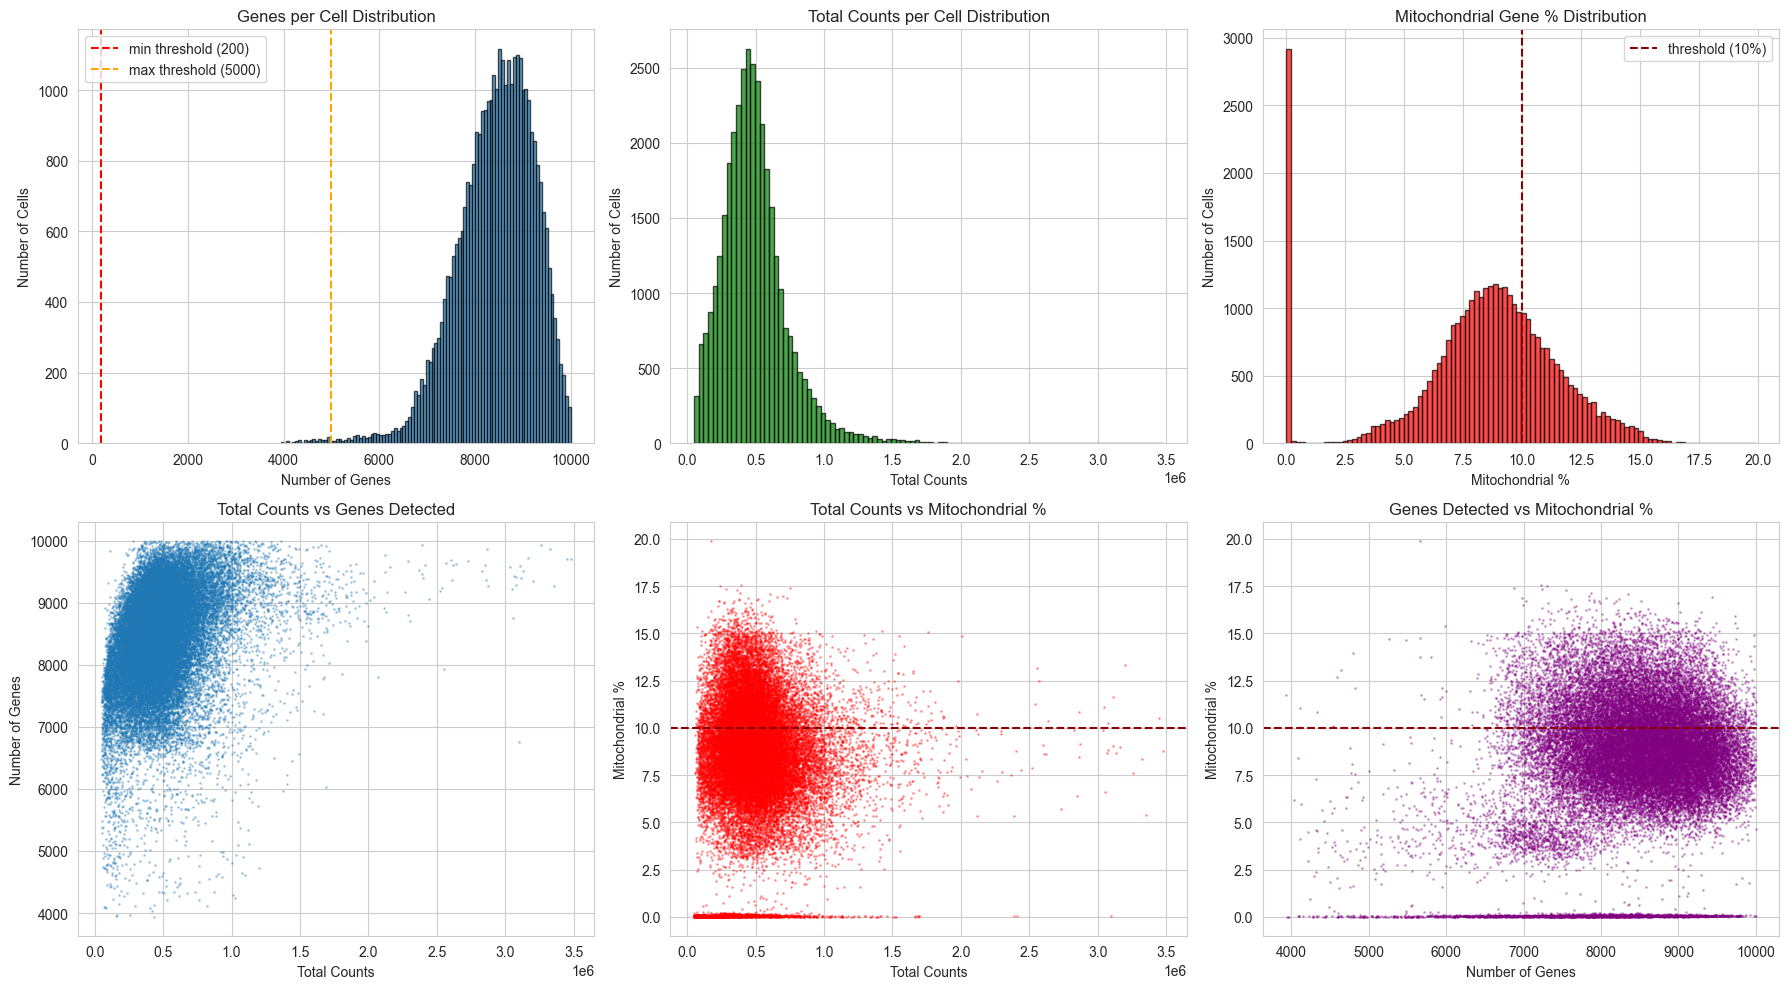

In [10]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Number of genes per cell
axes[0, 0].hist(adata.obs['n_genes_by_counts'], bins=100, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Number of Genes')
axes[0, 0].set_ylabel('Number of Cells')
axes[0, 0].set_title('Genes per Cell Distribution')
axes[0, 0].axvline(200, color='red', linestyle='--', label='min threshold (200)')
axes[0, 0].axvline(5000, color='orange', linestyle='--', label='max threshold (5000)')
axes[0, 0].legend()

# Total counts per cell
axes[0, 1].hist(adata.obs['total_counts'], bins=100, edgecolor='black', alpha=0.7, color='green')
axes[0, 1].set_xlabel('Total Counts')
axes[0, 1].set_ylabel('Number of Cells')
axes[0, 1].set_title('Total Counts per Cell Distribution')

# Mitochondrial percentage
axes[0, 2].hist(adata.obs['pct_counts_mt'], bins=100, edgecolor='black', alpha=0.7, color='red')
axes[0, 2].set_xlabel('Mitochondrial %')
axes[0, 2].set_ylabel('Number of Cells')
axes[0, 2].set_title('Mitochondrial Gene % Distribution')
axes[0, 2].axvline(10, color='darkred', linestyle='--', label='threshold (10%)')
axes[0, 2].legend()

# Scatter: Total counts vs Genes
axes[1, 0].scatter(adata.obs['total_counts'], adata.obs['n_genes_by_counts'],
                   alpha=0.3, s=1)
axes[1, 0].set_xlabel('Total Counts')
axes[1, 0].set_ylabel('Number of Genes')
axes[1, 0].set_title('Total Counts vs Genes Detected')

# Scatter: Total counts vs MT%
axes[1, 1].scatter(adata.obs['total_counts'], adata.obs['pct_counts_mt'],
                   alpha=0.3, s=1, color='red')
axes[1, 1].set_xlabel('Total Counts')
axes[1, 1].set_ylabel('Mitochondrial %')
axes[1, 1].set_title('Total Counts vs Mitochondrial %')
axes[1, 1].axhline(10, color='darkred', linestyle='--')

# Scatter: Genes vs MT%
axes[1, 2].scatter(adata.obs['n_genes_by_counts'], adata.obs['pct_counts_mt'],
                   alpha=0.3, s=1, color='purple')
axes[1, 2].set_xlabel('Number of Genes')
axes[1, 2].set_ylabel('Mitochondrial %')
axes[1, 2].set_title('Genes Detected vs Mitochondrial %')
axes[1, 2].axhline(10, color='darkred', linestyle='--')

plt.tight_layout()
plt.show()

In [11]:
# downsample and subset by day
adata.obs.day.value_counts()
     

day
day0    9526
day1    9339
day2    8449
day3    8433
Name: count, dtype: int64

In [12]:
# select top 203 HVG - following Squidiff training
sc.pp.highly_variable_genes(adata, n_top_genes=203, inplace=True)
# Subset adata to keep only highly variable genes
adata_hvg = adata[:, adata.var['highly_variable']]

print(f"Original AnnData object: {adata.n_obs} cells x {adata.n_vars} genes")
print(f"AnnData object with only highly variable genes: {adata_hvg.n_obs} cells x {adata_hvg.n_vars} genes")

Original AnnData object: 35747 cells x 11089 genes
AnnData object with only highly variable genes: 35747 cells x 203 genes


In [25]:
adata_hvg.obs["logtime"] = [np.log(int(x.split("ay")[-1])+2) for x in adata_hvg.obs["day"]]
adata_hvg.obs["logtime"].unique()

array([1.09861229, 1.60943791, 0.69314718, 1.38629436])

In [35]:
adata_hvg.obs["time_control"] = [x == 'day0' for x in adata_hvg.obs["day"]]

In [36]:
train_adata = adata_hvg[adata_hvg.obs.day.isin(['day0', 'day3'])]
test_adata = adata_hvg[adata_hvg.obs.day.isin(['day1','day2'])]
train_adata, test_adata

(View of AnnData object with n_obs × n_vars = 17959 × 203
     obs: 'assigned', 'auxDir', 'cell_filter', 'cell_name', 'compatible_fragment_ratio', 'day', 'donor', 'expected_format', 'experiment', 'frag_dist_length', 'gc_bias_correct', 'is_cell_control', 'is_cell_control_bulk', 'is_cell_control_control', 'library_types', 'libType', 'log10_total_counts', 'log10_total_counts_endogenous', 'log10_total_counts_ERCC', 'log10_total_counts_feature_control', 'log10_total_counts_MT', 'log10_total_features', 'log10_total_features_endogenous', 'log10_total_features_ERCC', 'log10_total_features_feature_control', 'log10_total_features_MT', 'mapping_type', 'mates1', 'mates2', 'n_alt_reads', 'n_total_reads', 'num_assigned_fragments', 'num_bias_bins', 'num_bootstraps', 'num_compatible_fragments', 'num_consistent_mappings', 'num_inconsistent_mappings', 'num_libraries', 'num_mapped', 'num_processed', 'num_targets', 'nvars_used', 'pct_counts_endogenous', 'pct_counts_ERCC', 'pct_counts_feature_control', 'pc

In [14]:
adata_hvg.obs.head()

,assigned,auxDir,cell_filter,cell_name,compatible_fragment_ratio,day,donor,expected_format,experiment,frag_dist_length,...,log1p_total_counts_mt,pct_counts_mt,total_counts_ribo,log1p_total_counts_ribo,pct_counts_ribo,total_counts_hb,log1p_total_counts_hb,pct_counts_hb,n_genes,n_counts
21843_1#10,1,aux_info,True,21843_1#10,0.999497,day1,joxm,IU,expt_09,1001,...,10.726809,7.669547,96207.695312,11.474275,16.195528,88.203224,4.490917,0.014848,8924,452270.218750
21843_1#100,1,aux_info,True,21843_1#100,0.999456,day1,fafq,IU,expt_09,1001,...,10.189380,12.086677,38854.718750,10.567611,17.643137,11.424891,2.519702,0.005188,7841,154752.796875
21843_1#101,1,aux_info,True,21843_1#101,0.999549,day1,fafq,IU,expt_09,1001,...,10.918259,9.535604,113442.007812,11.639056,19.606075,10.253790,2.420705,0.001772,8743,409990.656250
21843_1#102,1,aux_info,True,21843_1#102,0.999422,day1,wuye,IU,expt_09,1001,...,10.520755,7.833838,91020.750000,11.418854,19.231836,22.466600,3.155578,0.004747,8804,345184.468750
21843_1#103,1,aux_info,True,21843_1#103,0.999446,day1,joxm,IU,expt_09,1001,...,10.273335,7.209752,70494.164062,11.163300,17.556417,19.342791,3.012727,0.004817,8919,302085.343750


# Prepare CellFlow


In [16]:
import warnings
from pandas.errors import SettingWithCopyWarning

warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", SettingWithCopyWarning)

import numpy as np
import pandas as pd
import seaborn as sns
import jax
import functools
import matplotlib.pyplot as plt
import anndata as ad
import scanpy as sc
import rapids_singlecell as rsc
import flax.linen as nn
import optax
import cellflow
from cellflow.model import CellFlow
import cellflow.preprocessing as cfpp
from cellflow.utils import match_linear
from cellflow.plotting import plot_condition_embedding
from cellflow.preprocessing import transfer_labels, compute_wknn, centered_pca, project_pca, reconstruct_pca
from cellflow.metrics import compute_r_squared, compute_e_distance


INFO:2025-12-12 09:11:16,267:jax._src.xla_bridge:812: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
2025-12-12 09:11:16 | [INFO] Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
W1212 09:11:16.482328 2810163 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.


In [27]:
train_adata.obs["donor"].unique()

array(['fafq', 'wopl', 'sebz', 'hayt', 'garx', 'sojd', 'zapk', 'wibj',
       'jogf', 'pelm', 'vass', 'heth', 'toss', 'paab', 'oaqd', 'sita',
       'zoio', 'kajh', 'fasu', 'tout', 'iudw', 'tavh', 'dixh', 'fawm',
       'koqx', 'wigw', 'oebj', 'naju', 'eoxi', 'pulk', 'oojs', 'qayj',
       'guyj', 'seru', 'walu', 'babz', 'iisa', 'oikd', 'quls', 'sohd',
       'letw', 'oilg', 'rutc', 'vazt', 'sehl', 'oicx', 'suop', 'wahn',
       'aowh', 'cuhk', 'hegp', 'cicb', 'lepk', 'veku', 'ueah', 'puie',
       'lise', 'qoog', 'eiwy', 'zerv', 'kolf', 'uenn', 'iezw', 'wegi',
       'tolg', 'rayr', 'qaqx', 'yemz', 'wuye', 'joxm', 'bezi', 'kucg',
       'kefb', 'nosn', 'xojn', 'yoch', 'eipl', 'hoik', 'pahc', 'giju',
       'vuna', 'zihe', 'qihv', 'fiaj', 'bima', 'eesb', 'kuxp', 'yelp',
       'qunz', 'aoxv', 'melw', 'jejf', 'juuy', 'qehq', 'toco', 'pipw',
       'uilk', 'hajc', 'kuco', 'hecn', 'liqa', 'tert', 'ciwj', 'poih',
       'iiyk', 'miaj', 'laey', 'meue', 'vils', 'keui', 'naah', 'oibg',
      

In [37]:
cf = CellFlow(train_adata, solver="otfm")

In [38]:
cf.prepare_data(
    sample_rep = "X",
    control_key = "time_control",
    perturbation_covariates = {"time":("logtime",)},
    
    split_covariates = None,
    max_combination_length = 2,
    null_value = 0.0,
)

100%|██████████| 2/2 [00:00<00:00, 12.65it/s]


In [40]:
cf.prepare_validation_data(
    train_adata,
    name="train",
    n_conditions_on_log_iteration=None,
    n_conditions_on_train_end=None,
)

100%|██████████| 2/2 [00:00<00:00, 130.38it/s]


In [44]:
layers_before_pool = {
    "time": {"layer_type": "mlp", "dims": [512, 512], "dropout_rate": 0.0},
}

layers_after_pool = {
    "layer_type": "mlp", "dims": [1024, 1024], "dropout_rate": 0.0,
}

In [42]:
match_fn = functools.partial(match_linear, epsilon=0.5, tau_a=1.0, tau_b=1.0)

In [45]:
cf.prepare_model(
    condition_mode="deterministic",
    regularization=0.0,
    pooling="attention_token",
    layers_before_pool=layers_before_pool,
    layers_after_pool=layers_after_pool,
    condition_embedding_dim=256,
    cond_output_dropout=0.9,
    hidden_dims=[2048, 2048, 2048],
    decoder_dims=[4096, 4096, 4096],
    probability_path={"constant_noise": 0.5},
    match_fn=match_fn,
    )

In [46]:
metrics_callback = cellflow.training.Metrics(metrics=["mmd", "e_distance"])
callbacks = [metrics_callback]

In [47]:
cf.train(
        num_iterations=10_000,
        batch_size=2048,
        callbacks=callbacks,
        valid_freq=4_000,
    )

100%|██████████| 10000/10000 [06:30<00:00, 25.63it/s, loss=0.314] 


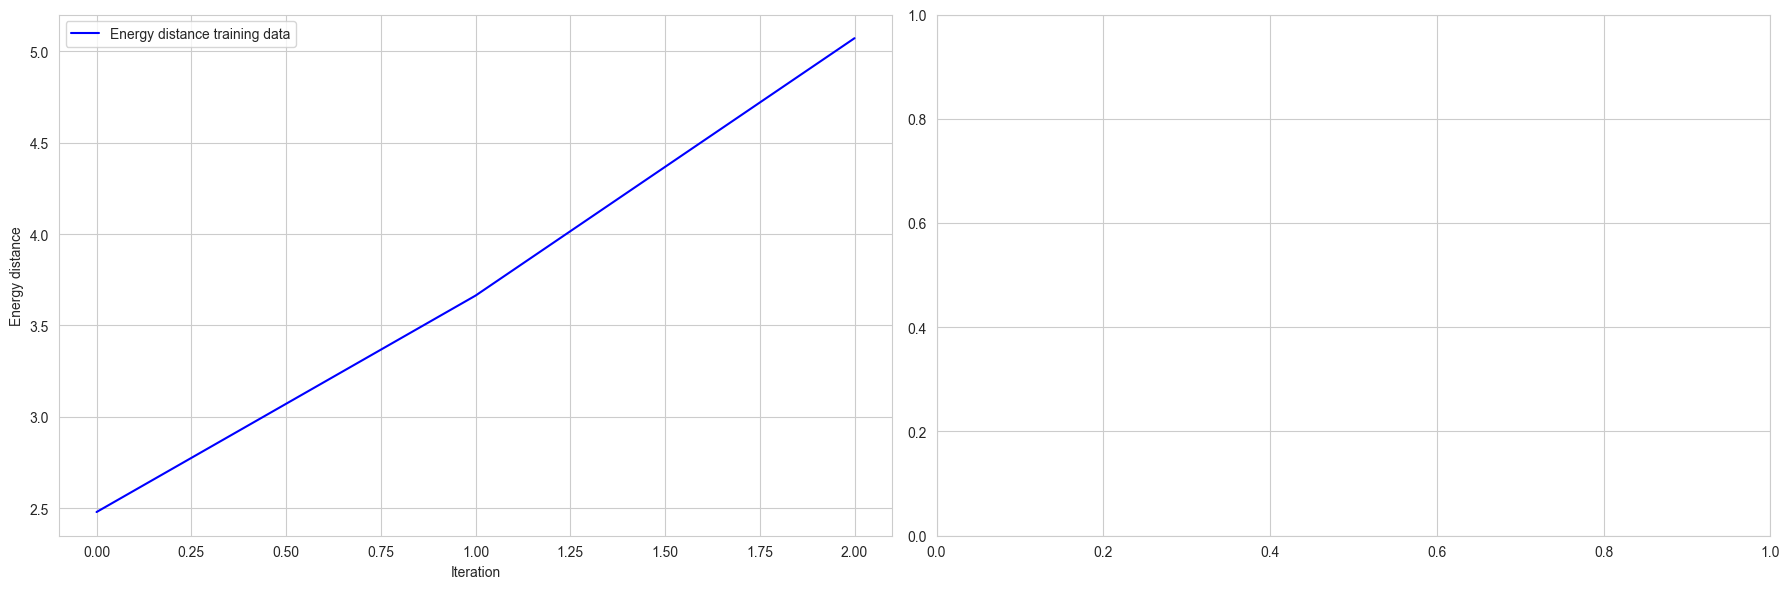

In [48]:
e_distances_train = cf.trainer.training_logs["train_e_distance_mean"]
#e_distances_test = cf.trainer.training_logs["test_e_distance_mean"]

iterations_train = np.arange(len(e_distances_train))
#iterations_test  = np.arange(len(e_distances_test))

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

axes[0].plot(iterations_train, e_distances_train, linestyle='-', color='blue', label='Energy distance training data')
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Energy distance')
axes[0].legend()
axes[0].grid(True)

#axes[1].plot(iterations_test, e_distances_test, linestyle='-', color='red', label='Energy distance test data')
#axes[1].set_xlabel('Validation iteration')
#axes[1].set_ylabel('Energy distance')
#axes[1].legend()
#axes[1].grid(True)

plt.tight_layout()
plt.show()